<img src="header.png" align="left"/>

# Exercise Import of excel data and timeseries prediction (10 points)

The goal of this example is to show the work with time series from Excel files and to develop a prediction model for time series. The data set describes the development of passenger numbers of an airline in the distant past. However, the data is typical for data as found in SME's (e.g. sales figures). 


The code for this example was adapted from [1]. Further information is available here [2]. 

- [1] [https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
- [2] [https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa](https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa)


Citation dataset:
```
Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. Third Edition. Holden-Day. Series G.
```


# Import of modules

In [1]:
import os
import openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = (16,9)

Using TensorFlow backend.


In [2]:
#
# handle error messages
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

In [3]:
#
# Für GPU Support
#
import tensorflow as tf
print ( tf.__version__ ) 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2.0.0


# Constants

In [4]:
excelData = 'data/airline_passengers.xlsx'

# Read the data from Excel file

In [5]:
#data = pd.ExcelFile(excelData)
#print(data.sheet_names)

In [6]:
#
# read one table
#
#df = data.parse('Tabellenblatt1')
df = pd.read_excel(excelData, header=3, usecols=[1,2,3])
df.info
df.head(10)

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
5,1949-06-01,135
6,1949-07-01,148
7,1949-08-01,148
8,1949-09-01,136
9,1949-10-01,119


In [7]:
df.tail()

,Month,Passengers
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


# Cut out data from pandas dataframes

Tutorial: [https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/](https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/)

<img src="info.png" align="left"/> 

In [8]:
#
# cut out data
#
# Task: cut out the data from the dataframe using the iloc function described above to have 
# only relevant data left (timestamp and passenger number, no NaNs) (2 points)
#

#df_cut = df.iloc[3:,1:]
#df_cut = df_cut.reset_index(drop=True)

### Antwort: 
columns and rows were selected in the readme excel above, I changed that to one command: `pd.read_excel(...)`

In [9]:
df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [10]:
# rename columns to fixed names
df.columns = ['month','passengers']

In [11]:
df.head()

,month,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


<AxesSubplot:>

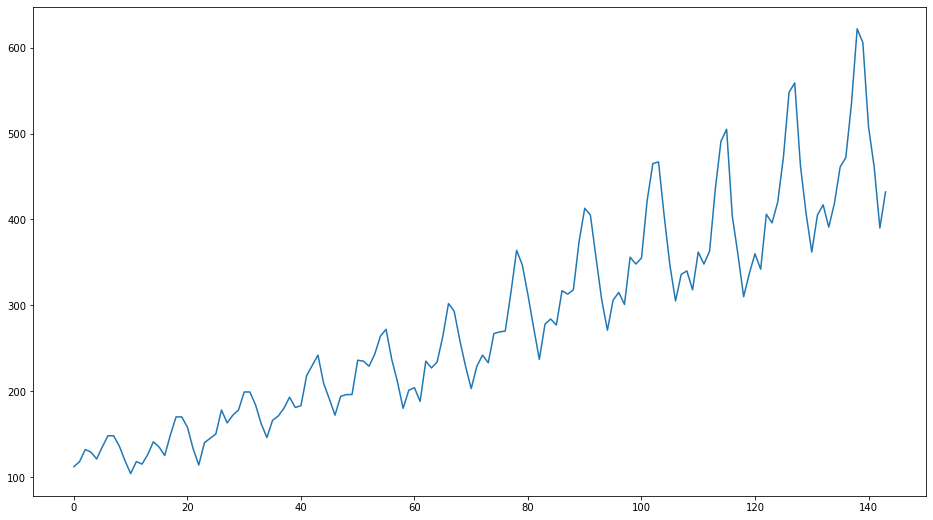

In [12]:
#
# plot number of passangers
#
# Task: plot the passenger data from the pandas dataframe (1 point)
#

df['passengers'].plot()

# Conventional methods

There are many older methods to work with time series:

- https://machinelearningmastery.com/time-series-trends-in-python/
- https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa


The main purpose of these methods is the calculation and use of parameters such as **trend** and **seasonality**. We hope that our models can handle them without us having to explicitly deal with them.

<img src="info.png" align="left"/> 

In [13]:
#
# prepare data
#
x_data = df['passengers'].to_numpy()
x_data = x_data.astype('float32')
x_data = np.reshape(x_data,(-1,1))
print(x_data)

[[112.]
 [118.]
 [132.]
 [129.]
 [121.]
 [135.]
 [148.]
 [148.]
 [136.]
 [119.]
 [104.]
 [118.]
 [115.]
 [126.]
 [141.]
 [135.]
 [125.]
 [149.]
 [170.]
 [170.]
 [158.]
 [133.]
 [114.]
 [140.]
 [145.]
 [150.]
 [178.]
 [163.]
 [172.]
 [178.]
 [199.]
 [199.]
 [184.]
 [162.]
 [146.]
 [166.]
 [171.]
 [180.]
 [193.]
 [181.]
 [183.]
 [218.]
 [230.]
 [242.]
 [209.]
 [191.]
 [172.]
 [194.]
 [196.]
 [196.]
 [236.]
 [235.]
 [229.]
 [243.]
 [264.]
 [272.]
 [237.]
 [211.]
 [180.]
 [201.]
 [204.]
 [188.]
 [235.]
 [227.]
 [234.]
 [264.]
 [302.]
 [293.]
 [259.]
 [229.]
 [203.]
 [229.]
 [242.]
 [233.]
 [267.]
 [269.]
 [270.]
 [315.]
 [364.]
 [347.]
 [312.]
 [274.]
 [237.]
 [278.]
 [284.]
 [277.]
 [317.]
 [313.]
 [318.]
 [374.]
 [413.]
 [405.]
 [355.]
 [306.]
 [271.]
 [306.]
 [315.]
 [301.]
 [356.]
 [348.]
 [355.]
 [422.]
 [465.]
 [467.]
 [404.]
 [347.]
 [305.]
 [336.]
 [340.]
 [318.]
 [362.]
 [348.]
 [363.]
 [435.]
 [491.]
 [505.]
 [404.]
 [359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]


In [14]:
#
# Normalize the dataset
#
# Task: create a minmax scaler from sklearn to scale the data between 0 and 1 and store the trained scaler in
# a python variable called scaler (2 points)
#
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
scaler.fit(x_data)

MinMaxScaler(feature_range=(0.0, 1.0))

In [15]:
print(scaler.data_max_)

[622.]


In [16]:
#
# actually scale the data
#
x_data = scaler.transform(x_data)
print(x_data)

[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]
 [0.08494207]
 [0.08494207]
 [0.06177607]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123553]
 [0.04247104]
 [0.07142857]
 [0.05984557]
 [0.04054055]
 [0.08687258]
 [0.12741312]
 [0.12741312]
 [0.10424709]
 [0.05598456]
 [0.01930502]
 [0.06949806]
 [0.07915059]
 [0.08880308]
 [0.14285713]
 [0.11389962]
 [0.13127413]
 [0.14285713]
 [0.18339768]
 [0.18339768]
 [0.15444016]
 [0.11196911]
 [0.08108109]
 [0.1196911 ]
 [0.12934363]
 [0.14671814]
 [0.17181468]
 [0.14864865]
 [0.15250966]
 [0.22007722]
 [0.24324325]
 [0.26640925]
 [0.2027027 ]
 [0.16795367]
 [0.13127413]
 [0.17374519]
 [0.17760617]
 [0.17760617]
 [0.25482625]
 [0.25289574]
 [0.24131274]
 [0.26833975]
 [0.3088803 ]
 [0.32432434]
 [0.25675675]
 [0.20656371]
 [0.14671814]
 [0.18725869]
 [0.19305018]
 [0.16216215]
 [0.25289574]
 [0.23745173]
 [0.25096524]
 [0.3088803 ]
 [0.38223937]
 [0.36486486]
 [0.2992278 ]
 [0.24131274]
 [0.1911197 ]
 [0.24

In [17]:
#
# split into train and test sets with 80% training data
#
train_size = int(len(x_data) * 0.80)
test_size = len(x_data) - train_size
train, test = x_data[0:train_size,:], x_data[train_size:len(x_data),:]
print(len(train), len(test))

115 29


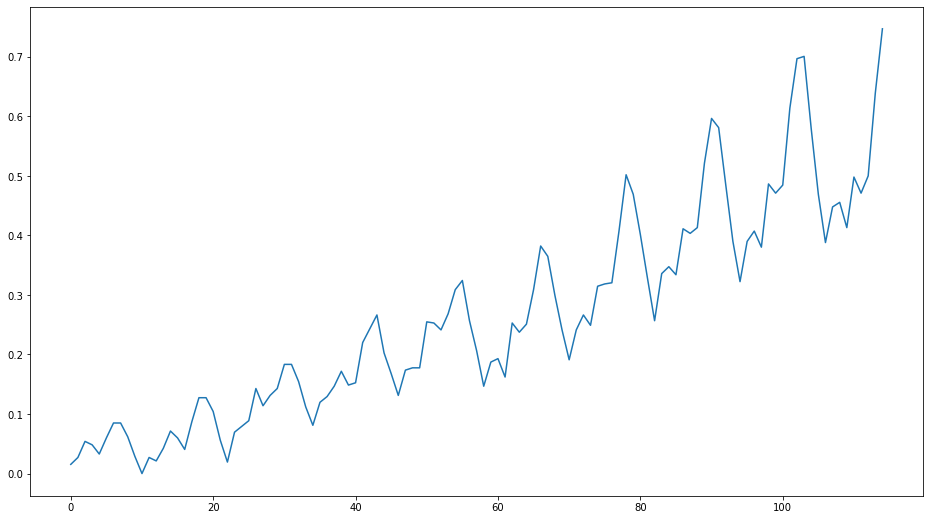

In [18]:
#
# plot scaled training data for check
#
plt.plot(train)

# Create a training data set with sliding windows

Sliding windows are created from a time series by dragging a window over the entire time series and copying the data in the window. More details here [https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe](https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe).

<img src="info.png" align="left"/> 

In [19]:
#
# create sliding windows with one label (y)
#
# Task: add comments for the details of this function (1 point)
#
def createSlidingWindowsWithLabel(dataset, window_length=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-window_length-1):
        a = dataset[ i:(i+window_length), 0]
        dataX.append(a)
        dataY.append(dataset[i + window_length, 0])
    return np.array(dataX), np.array(dataY)

In [20]:
#
# apply sliding window function with window size (window_length)
#
window_length = 1
trainX, trainY = createSlidingWindowsWithLabel(train, window_length)
testX, testY = createSlidingWindowsWithLabel(test, window_length)

In [21]:
# 
# reshape input to be [samples, time steps, features]
#
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0],testX.shape[1],  1))

In [22]:
print(trainX)

[[[0.01544401]]

 [[0.02702703]]

 [[0.05405405]]

 [[0.04826255]]

 [[0.03281853]]

 [[0.05984557]]

 [[0.08494207]]

 [[0.08494207]]

 [[0.06177607]]

 [[0.02895753]]

 [[0.        ]]

 [[0.02702703]]

 [[0.02123553]]

 [[0.04247104]]

 [[0.07142857]]

 [[0.05984557]]

 [[0.04054055]]

 [[0.08687258]]

 [[0.12741312]]

 [[0.12741312]]

 [[0.10424709]]

 [[0.05598456]]

 [[0.01930502]]

 [[0.06949806]]

 [[0.07915059]]

 [[0.08880308]]

 [[0.14285713]]

 [[0.11389962]]

 [[0.13127413]]

 [[0.14285713]]

 [[0.18339768]]

 [[0.18339768]]

 [[0.15444016]]

 [[0.11196911]]

 [[0.08108109]]

 [[0.1196911 ]]

 [[0.12934363]]

 [[0.14671814]]

 [[0.17181468]]

 [[0.14864865]]

 [[0.15250966]]

 [[0.22007722]]

 [[0.24324325]]

 [[0.26640925]]

 [[0.2027027 ]]

 [[0.16795367]]

 [[0.13127413]]

 [[0.17374519]]

 [[0.17760617]]

 [[0.17760617]]

 [[0.25482625]]

 [[0.25289574]]

 [[0.24131274]]

 [[0.26833975]]

 [[0.3088803 ]]

 [[0.32432434]]

 [[0.25675675]]

 [[0.20656371]]

 [[0.14671814]

# Create an LSTM model

In [23]:
# some hyperparameters
epochs = 100
batch_size = 4

In [24]:
#
# create and fit the LSTM network
#
def createLSTMModel():
    model = Sequential()
    model.add(LSTM(6, input_shape=(window_length, 1)))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [25]:
lstm_model = createLSTMModel()

In [26]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = lstm_model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(testX, testY), shuffle=False)

Train on 113 samples, validate on 27 samples
Epoch 1/100
113/113 [==============================] - 2s 16ms/step - loss: 0.0398 - val_loss: 0.1689
Epoch 2/100
113/113 [==============================] - 0s 846us/step - loss: 0.0228 - val_loss: 0.1201
Epoch 3/100
113/113 [==============================] - 0s 889us/step - loss: 0.0150 - val_loss: 0.0881
Epoch 4/100
113/113 [==============================] - 0s 958us/step - loss: 0.0120 - val_loss: 0.0684
Epoch 5/100
113/113 [==============================] - 0s 831us/step - loss: 0.0111 - val_loss: 0.0566
Epoch 6/100
113/113 [==============================] - 0s 818us/step - loss: 0.0108 - val_loss: 0.0494
Epoch 7/100
113/113 [==============================] - 0s 872us/step - loss: 0.0106 - val_loss: 0.0447
Epoch 8/100
113/113 [==============================] - 0s 806us/step - loss: 0.0103 - val_loss: 0.0412
Epoch 9/100
113/113 [==============================] - 0s 817us/step - loss: 0.0099 - val_loss: 0.0383
Epoch 10/100
113/113 [=======

113/113 [==============================] - 0s 832us/step - loss: 0.0027 - val_loss: 0.0122
Epoch 80/100
113/113 [==============================] - 0s 802us/step - loss: 0.0027 - val_loss: 0.0122
Epoch 81/100
113/113 [==============================] - 0s 789us/step - loss: 0.0027 - val_loss: 0.0122
Epoch 82/100
113/113 [==============================] - 0s 844us/step - loss: 0.0027 - val_loss: 0.0121
Epoch 83/100
113/113 [==============================] - 0s 798us/step - loss: 0.0027 - val_loss: 0.0121
Epoch 84/100
113/113 [==============================] - 0s 767us/step - loss: 0.0027 - val_loss: 0.0121
Epoch 85/100
113/113 [==============================] - 0s 846us/step - loss: 0.0027 - val_loss: 0.0121
Epoch 86/100
113/113 [==============================] - 0s 781us/step - loss: 0.0027 - val_loss: 0.0121
Epoch 87/100
113/113 [==============================] - 0s 769us/step - loss: 0.0027 - val_loss: 0.0121
Epoch 88/100
113/113 [==============================] - 0s 845us/step - loss:

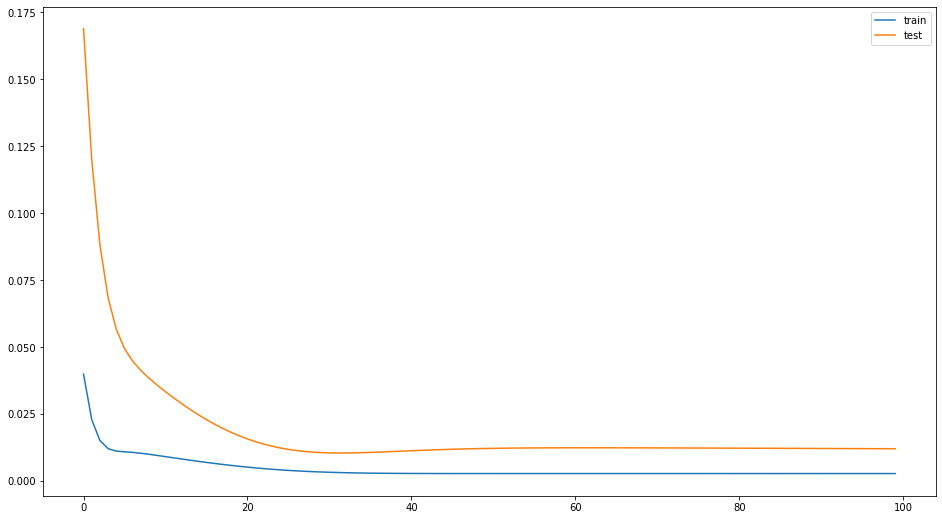

In [28]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [29]:
#
# Estimate values for train and test data
#
trainPredict = lstm_model.predict(trainX)
testPredict = lstm_model.predict(testX)

In [30]:
#
# Inverse transformation of estimations (scaler)
#
trainPredicti = scaler.inverse_transform(trainPredict)
testPredicti = scaler.inverse_transform(testPredict)

trainYi = scaler.inverse_transform([trainY])
testYi = scaler.inverse_transform([testY])

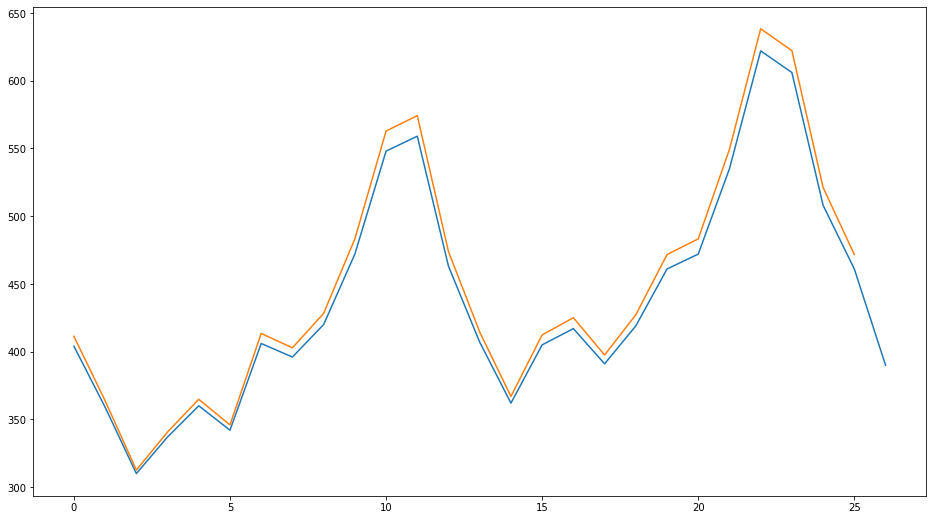

In [31]:
#
# Plot estimations
#
plt.plot(testYi[0,0:])
plt.plot(testPredicti[1:,0])
plt.show()

In [41]:
#
# calculate root mean squared error
#
# Task: calculate the root mean squared error between the test labels and the prediction (1 point)
# Hint: labels are in testYi[0,0:-1]
#       predictions are in testPredicti[1:,0]

trainScore = math.sqrt(mean_squared_error(trainYi[0,0:-1], trainPredicti[1:,0]))
trainScore2 = math.sqrt(mean_squared_error(trainYi[0], trainPredicti[:,0]))
print('train loss: %.3f RMSE %.3f' % (trainScore, trainScore2))
testScore = math.sqrt(mean_squared_error(testYi[0,0:-1], testPredicti[1:,0]))
testScore2 = math.sqrt(mean_squared_error(testYi[0], testPredicti[:,0]))
print('test loss: %.3f RMSE %.3f' % (testScore, testScore2))

train loss: 4.634 RMSE 26.696
test loss: 9.920 RMSE 56.620


### Antwort:
Warum anders als in Artikel? RSME erheblich unterschiedlich

In [57]:
trainPredicti[1:,0]

array([126.59594 , 139.01974 , 136.33904 , 129.23956 , 141.71039 ,
       153.48254 , 153.48254 , 142.60948 , 127.476006, 114.39638 ,
       126.59594 , 123.9626  , 133.6683  , 147.12112 , 141.71039 ,
       132.7803  , 154.39557 , 173.8062  , 173.8062  , 162.65952 ,
       139.91554 , 123.08713 , 146.21664 , 150.74986 , 155.30962 ,
       181.3161  , 167.28645 , 175.67789 , 181.3161  , 201.31462 ,
       201.31462 , 186.98856 , 166.35904 , 151.65971 , 170.07468 ,
       174.74155 , 183.20312 , 195.55986 , 184.14809 , 186.04082 ,
       219.74232 , 231.53217 , 243.43126 , 210.97562 , 193.64874 ,
       175.67789 , 196.51675 , 198.43326 , 198.43326 , 237.46849 ,
       236.47723 , 230.54543 , 244.42757 , 265.50745 , 273.61227 ,
       238.46046 , 212.91798 , 183.20312 , 203.23994 , 206.13438 ,
       190.78886 , 236.47723 , 228.5742  , 235.48672 , 265.50745 ,
       304.3258  , 295.06232 , 260.46207 , 230.54543 , 205.16872 ,
       230.54543 , 243.43126 , 234.49698 , 268.54218 , 270.568

# Plot complete timeline

In [59]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(x_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[:len(trainPredicti)+0, :] = trainPredicti

# shift test predictions for plotting
testPredictPlot = np.empty_like(x_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredicti)+(window_length*2):len(x_data)-2, :] = testPredicti

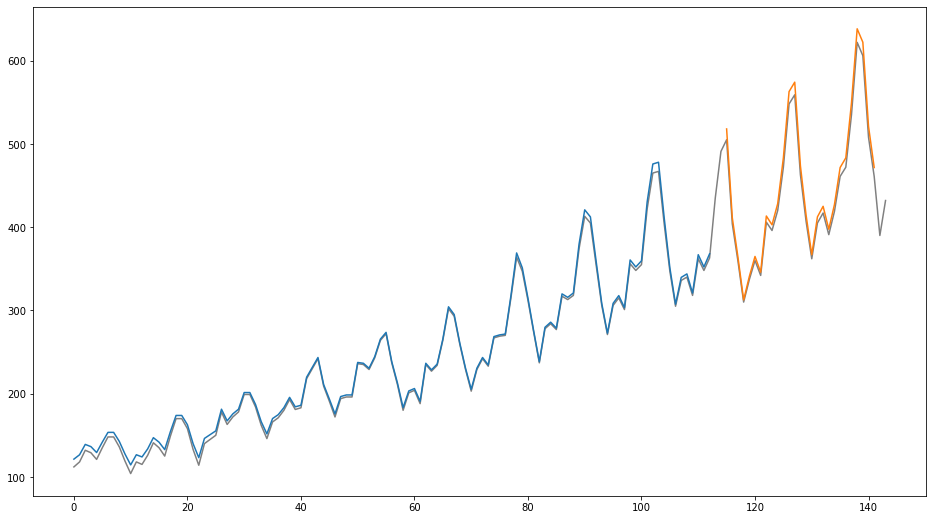

In [60]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(x_data), color='grey')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Experiment with different window and model sizes (3 points)

**change request**: The customer wants a better prediction quality. Conduct an experiment with a different window_length. Another option is to increase the capacity of the model. Compare the resulting RMSE values. 
Hopefully, this increases the quality of the prediction.

In [77]:
#
# apply sliding window function with window size (window_length)
#
window_length = 7
itrainX, itrainY = createSlidingWindowsWithLabel(train, window_length)
itestX, itestY = createSlidingWindowsWithLabel(test, window_length)

In [78]:
itrainX = np.reshape(itrainX, (itrainX.shape[0], itrainX.shape[1], 1))
itestX = np.reshape(itestX, (itestX.shape[0], itestX.shape[1],  1))

In [79]:
# check shape of windows
print(itrainX.shape)

(107, 7, 1)


In [80]:
improved_lstm_model = createLSTMModel()

In [81]:
improved_lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [82]:
improved_history = improved_lstm_model.fit(itrainX, itrainY, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(itestX, itestY), shuffle=False)

Train on 107 samples, validate on 21 samples
Epoch 1/100
107/107 [==============================] - 2s 18ms/step - loss: 0.0406 - val_loss: 0.1901
Epoch 2/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0145 - val_loss: 0.1039
Epoch 3/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0759
Epoch 4/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0673
Epoch 5/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0605
Epoch 6/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0536
Epoch 7/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0473
Epoch 8/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0419
Epoch 9/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0373
Epoch 10/100
107/107 [=======================

Epoch 81/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0176
Epoch 82/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0175
Epoch 83/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0175
Epoch 84/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0174
Epoch 85/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0174
Epoch 86/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0173
Epoch 87/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0172
Epoch 88/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0172
Epoch 89/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0171
Epoch 90/100
107/107 [==============================] - 0s 2ms/step - loss: 0.0042

In [83]:
#
# Estimate values for train and test data
#
itrainPredict = improved_lstm_model.predict(itrainX)
itestPredict = improved_lstm_model.predict(itestX)#
# Inverse transformation of estimations (scaler)
#
itrainPredicti = scaler.inverse_transform(itrainPredict)
itestPredicti = scaler.inverse_transform(itestPredict)

itrainYi = scaler.inverse_transform([itrainY])
itestYi = scaler.inverse_transform([itestY])

In [84]:
itrainScore = math.sqrt(mean_squared_error(itrainYi[0,0:-1], itrainPredicti[1:,0]))
itrainScore2 = math.sqrt(mean_squared_error(itrainYi[0], itrainPredicti[:,0]))
print('train loss: %.3f RMSE %.3f' % (itrainScore, itrainScore2))
itestScore = math.sqrt(mean_squared_error(itestYi[0,0:-1], itestPredicti[1:,0]))
itestScore2 = math.sqrt(mean_squared_error(itestYi[0], itestPredicti[:,0]))
print('test loss: %.3f RMSE %.3f' % (itestScore, itestScore2))

train loss: 18.826 RMSE 32.755
test loss: 36.710 RMSE 66.414
